# PLS Implementation

In [ ]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
#plt.style.use('/Users/yanmuller/Desktop/pitayasmoothie-light.mplstyle')

def pls_algorithm(X, y, n_components):
    
    # Standardize
    y_mean = np.mean(y)
    y_std = np.std(y)
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0) + 1e-8
    # Center and scale X
    X = (X - X_mean) / X_std
    #print("Shape of X after scaling:", X.shape)
    
    # Center and scale y
    y = (y - y_mean) / y_std
    #print("Shape of y after scaling:", y.shape)
    
    X = np.array(X)  # Ensure X is a NumPy array
    y = np.array(y).reshape(-1, 1)  # Ensure y is reshaped to (n_samples, 1)

    T, P, W, C = [], [], [], []  # Initialize matrices
    
    for i in range(n_components):
        #print(f"\nIteration {i+1}:")
       
        S = X.T @ y @ y.T @ X  # Compute covariance matrix
        #print("Shape of S:", S.shape)
        
        eigenvalues, eigenvectors = np.linalg.eig(S)
        w = eigenvectors[:, np.argmax(eigenvalues)]
        w /= np.linalg.norm(w)  # Normalize
        #print("Shape of w:", w.shape)
       
        t = (X @ w).reshape(-1, 1)
        #print("Shape of t:", t.shape)
        
        p = (X.T @ t) / (t.T @ t).reshape(-1, 1)
        #print("Shape of p:", p.shape)
        
        c = (t.T @ y) / (t.T @ t).reshape(-1, 1)
        #print("Shape of c:", c.shape)
       
        X = X - np.outer(t, p)
       
        y = y - c * t
        
        T.append(t)
        P.append(p)
        W.append(w)
        C.append(c)

    T = np.array(T).squeeze().T  
    P = np.array(P).squeeze().T
    W = np.array(W).squeeze().T
    C = np.array(C).squeeze().T

    T = np.real(T)
    #print("Final shapes:")
    #print("T:", T.shape)
    #print("P:", P.shape)
    #print("W:", W.shape)
    #print("C:", C.shape)
    
    return T, P, W, C


def predict(X, W, P, C, y):
    y_mean = np.mean(y)
    y_std = np.std(y)
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0) + 1e-8
    X_scaled = (X - X_mean) / X_std
    #print("Shape of X_scaled:", X_scaled.shape)
    
    W_star = W @ np.linalg.inv(P.T @ W)
    T = X_scaled @ W_star
    #print("Shape of T (scores):", T.shape)
    
    y_pred = T @ C
    y_pred_original = (y_pred * y_std) + y_mean
    y_pred_original = np.real(y_pred_original)
    T = np.real(T)
    #print("Tshape:",T.shape)
 
    X_recon_scaled = T @ P.T
    recon_error = np.linalg.norm(X_scaled - X_recon_scaled) / np.linalg.norm(X_scaled)
    print(f"[Debug] Rekonstruction error (X_scaled ≈ T @ Pᵀ): {recon_error:.4e}")
     

    return y_pred_original, T



## PLS Linear Example

[Debug] Rekonstruktionsfehler (X_scaled ≈ T @ Pᵀ): 8.4169e-01
[Debug] Rekonstruktionsfehler (X_scaled ≈ T @ Pᵀ): 7.8147e-01
[Debug] Rekonstruktionsfehler (X_scaled ≈ T @ Pᵀ): 7.1671e-01
[Debug] Rekonstruktionsfehler (X_scaled ≈ T @ Pᵀ): 6.7942e-01
[Debug] Rekonstruktionsfehler (X_scaled ≈ T @ Pᵀ): 6.1370e-01
[Debug] Rekonstruktionsfehler (X_scaled ≈ T @ Pᵀ): 5.3788e-01
[Debug] Rekonstruktionsfehler (X_scaled ≈ T @ Pᵀ): 4.3485e-01
[Debug] Rekonstruktionsfehler (X_scaled ≈ T @ Pᵀ): 3.1310e-01
[Debug] Rekonstruktionsfehler (X_scaled ≈ T @ Pᵀ): 1.9858e-16


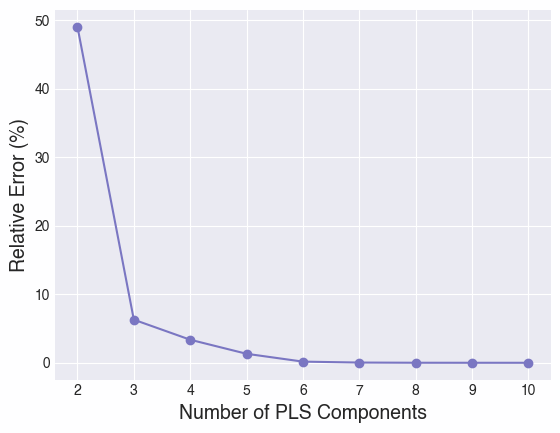

Comp. | Rel. Err | TProj | TPred | Ttot
----------------------------------------------------------------------
  2 |         49.07 |        0.0016 |        0.0006 |        0.0023
  3 |          6.30 |        0.0024 |        0.0004 |        0.0028
  4 |          3.37 |        0.0010 |        0.0003 |        0.0014
  5 |          1.31 |        0.0014 |        0.0004 |        0.0018
  6 |          0.17 |        0.0014 |        0.0004 |        0.0018
  7 |          0.03 |        0.0021 |        0.0006 |        0.0027
  8 |          0.01 |        0.0025 |        0.0004 |        0.0029
  9 |          0.00 |        0.0026 |        0.0004 |        0.0030
 10 |          0.00 |        0.0021 |        0.0004 |        0.0025
----------------------------------------------------------------------


In [14]:
#PLS Example
n_features=10

np.random.seed(42)
X_example = np.random.randn(5*n_features, n_features)

A = np.random.randn(n_features)
b= np.random.randn()

y_example = X_example @ A + b


import time

n_components_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
results = []
ys = []

for n in n_components_list:
    
    start_total = time.time()
    
    start_pls = time.time()
    T, P, W, C = pls_algorithm(X_example, y_example, n)
    end_pls = time.time()
    
    start_pred = time.time()
    y_pred, T2 = predict(X_example, W, P, C, y_example)
    end_pred = time.time()
    
    end_total = time.time()
    ys.append(y_pred)
    rel_err_pls = np.mean(np.abs((y_example - y_pred) / y_example)) * 100

    pls_time = end_pls - start_pls
    pred_time = end_pred - start_pred
    total_time = end_total - start_total
    
    results.append({
        "components": n,
        "rel_error": rel_err_pls,
        "time_total": total_time,
        "time_pls": pls_time,
        "time_pred": pred_time
    })

plt.plot( [r["components"] for r in results], [r["rel_error"] for r in results], marker='o')
plt.xlabel("Number of PLS Components", fontsize=14)
plt.ylabel("Relative Error (%)", fontsize=14)
#plt.title("PLS  Relative Error vs. Number of Components",fontsize= 20)
plt.grid(True)
plt.show() 


print("Comp. | Rel. Err | TProj | TPred | Ttot")
print("-" * 70)
for row in results:
    print(f"{row['components']:>3} |"
        f" {row['rel_error']:>13.2f} |"
        f" {row['time_pls']:>13.4f} |"
        f" {row['time_pred']:>13.4f} |"
        f" {row['time_total']:>13.4f}")
print("-" * 70)

## LR No dimensionality reduction

In [ ]:

def LRnoPLS(n_components):
   

    start_plain = time.time()
    reg_plain = LinearRegression()
    reg_plain.fit(X_train_scaled, y_train_scaled)
    train_plain_time = time.time()

    # Test pred
    y_pred_test_scaled = reg_plain.predict(X_test_scaled)
    y_pred_test = y_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
    pred_plain_time = time.time()

    # Training pred
    y_pred_train_scaled = reg_plain.predict(X_train_scaled)
    y_pred_train = y_scaler.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()

    # Error Test
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    rel_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    mse_test = (mean_squared_error(y_test, y_pred_test))

    # Error Train
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)
    rel_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

    # Plot
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred_test, alpha=0.6, label="LR Plain")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label="perfect prediction")
    plt.xlabel("Real values", fontsize=14)
    plt.ylabel("Predicted values", fontsize=14)
    plt.title(f"LR Plain", fontsize=20)
    plt.legend(loc='upper left', fontsize = 12)
    plt.grid(True)
    plt.ylim(-2000, 14000)
    plt.xlim(0, y_test.max())
    plt.show()

    # Training Plot
    """plt.figure(figsize=(8,6))
    plt.scatter(y_train, y_pred_train, alpha=0.6, label="LR without PLS (Train)")
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'k--', label="perfect prediction")
    plt.xlabel("real values")
    plt.ylabel("predicted values")
    plt.title("Linear Regression without PLS - Train")
    plt.legend()
  
    plt.show()"""

    print("lr train:", np.mean(np.abs(y_train - y_pred_train) / np.abs(y_train)) * 100 )

    return {
        
        "mae_plain_test": mae_test,
        "rmse_plain_test": rmse_test,
        "r2_plain_test": r2_test,
        "rel_plain_test": rel_test,
        "mse_test": mse_test,
       
        "mae_plain_train": mae_train,
        "rmse_plain_train": rmse_train,
        "r2_plain_train": r2_train,
        "rel_plain_train": rel_train,

       
        "time_total": pred_plain_time - start_plain,
        "time_train": train_plain_time - start_plain,
        "time_pred": pred_plain_time - train_plain_time,

        "y_pred_test": y_pred_test,
        "y_pred_train": y_pred_train
    }


## LR with PLS

In [ ]:

def LRPLSSk(n_components):
    

    start_pls = time.time()

    # --- PLS Training ---
    start_pls_proj = time.time()
    pls = PLSRegression(n_components=n_components)
    T_train = pls.fit_transform(X_train_scaled, y_train_scaled)[0]
    T_test = pls.transform(X_test_scaled)

    # --- MinMax PLS comp. ---
    scaler_T = MinMaxScaler()
    T_train_scaled = scaler_T.fit_transform(T_train)
    T_test_scaled = scaler_T.transform(T_test)
    end_pls_proj = time.time()

    # --- Training ---
    start_pls_train = time.time()
    reg_plain_pls = LinearRegression()
    reg_plain_pls.fit(T_train_scaled, y_train_scaled)
    end_pls_train = time.time()

    # --- Test Prediction ---
    start_pls_pred = time.time()
    y_pred_test_scaled = reg_plain_pls.predict(T_test_scaled)
    y_pred_test = y_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
    end_pls_pred = time.time()
    end_pls = time.time()

    # --- Train Prediction ---
    y_pred_train_scaled = reg_plain_pls.predict(T_train_scaled)
    y_pred_train = y_scaler.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()

    # --- Errors ---
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    rel_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    mse_test = (mean_squared_error(y_test, y_pred_test))

    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)
    rel_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

    # --- Plot: Test ---
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred_test, color="#e91e63", alpha=0.6, label="LR with PLS")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label="perfect prediction")
    plt.xlabel("Real values", fontsize=14)
    plt.ylabel("Predicted values", fontsize=14)
    plt.title(f"LR with PLS, {n_components} components", fontsize=20)
    plt.legend(loc='upper left', fontsize = 12)
    plt.ylim(-2000, 14000)
    plt.xlim(0, y_test.max())
    plt.grid(True)
    plt.show()

    print("rl pls", rel_train)

    return {

        "mae_pls_test": mae_test,
        "rmse_pls_test": rmse_test,
        "r2_pls_test": r2_test,
        "rel_pls_test": rel_test,
        "mse_test": mse_test,


        "mae_pls_train": mae_train,
        "rmse_pls_train": rmse_train,
        "r2_pls_train": r2_train,
        "rel_pls_train": rel_train,


        "time_pls_total": end_pls - start_pls,
        "time_pls_proj": end_pls_proj - start_pls_proj,
        "time_pls_train": end_pls_train - start_pls_train,
        "time_pls_pred": end_pls_pred - start_pls_pred,


        "y_pred_test": y_pred_test,
        "y_pred_train": y_pred_train
    }


## LR with PCA

In [ ]:

def LRPCR(n_components):
    scaler_pcr = MinMaxScaler()
    start_pcr = time.time()

    proj_start = time.time()
    # Center scaled training data
    X_centered = X_train_scaled - np.mean(X_train_scaled, axis=0)

   
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    top_components = Vt.T[:, :n_components]

    X_pca = X_centered @ top_components
    X_pca = scaler_pcr.fit_transform(X_pca)
    proj_end = time.time()

    train_start = time.time()

    reg_pcr = LinearRegression()
    reg_pcr.fit(X_pca, y_train_scaled)

    train_end=time.time()


    # Apply same transformation to scaled test data
    start_pred = time.time()

    X_test_centered = X_test_scaled - np.mean(X_train_scaled, axis=0)
    X_test_pca = X_test_centered @ top_components
    X_test_pca = scaler_pcr.transform(X_test_pca)
    

    y_pred_scaled = reg_pcr.predict(X_test_pca)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    pred_end = time.time()


    mae_test = mean_absolute_error(y_test, y_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_test = r2_score(y_test, y_pred)
    rel_test = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mse_test = mean_squared_error(y_test, y_pred)

    y_pred_train_scaled = reg_pcr.predict(X_pca)
    y_pred_train = y_scaler.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()

    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)
    rel_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, color="tab:purple", alpha=0.6, label="LR with PCA")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label="perfect prediction")
    plt.xlabel("Real values", fontsize=14)
    plt.ylabel("Predicted values", fontsize=14)
    plt.title(f"LR with PCA, {n_components} components", fontsize=20)
    plt.legend(loc='upper left', fontsize = 12)
    plt.grid(True)
    plt.ylim(-2000, 14000)
    plt.xlim(0, y_test.max())
    plt.show()

    #training plot
    """plt.figure(figsize=(8,6))
    plt.scatter(y_train, y_pred_train, color="tab:purple", alpha=0.6, label="LR with PCR (Train)")
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'k--', label="perfect prediction")
    plt.xlabel("real values")
    plt.ylabel("predicted values")
    plt.title("Linear Regression with PCR - Train")
    plt.legend()
    plt.show()"""

    print("lrpcr train:", np.mean(np.abs(y_train - y_pred_train) / np.abs(y_train)) * 100 )

 
    time_total = pred_end - start_pcr 
    time_proj = proj_end - proj_start 
    time_train = train_end - train_start #
    time_pred = pred_end - start_pred

    return {
       
        "mae_pcr_test": mae_test,
        "rmse_pcr_test": rmse_test,
        "r2_pcr_test": r2_test,
        "rel_pcr_test": rel_test,
        "mse_test": mse_test,

     
        "mae_pcr_train": mae_train,
        "rmse_pcr_train": rmse_train,
        "r2_pcr_train": r2_train,
        "rel_pcr_train": rel_train,
    
        "time_pcr_total": time_total,
        "time_pcr_proj": time_proj,
        "time_pcr_train": time_train,
        "time_pcr_pred": time_pred
    }



## GP No dimensionality reduction

In [ ]:

def GPnoPLS():
    

    # --- Total time start ---
    start_gp_plain_total = time.time()

    # --- GP model ---
    gp_plain = GaussianProcessRegressor(kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)), n_restarts_optimizer=10)
    #gp_plain=GaussianProcessRegressor()
    # --- Training ---
    start_gp_plain_train = time.time()
    gp_plain.fit(X_train_scaled, y_train_scaled)
    end_gp_plain_train = time.time()

    # --- Prediction (Test set) ---
    start_gp_plain_pred = time.time()
    y_pred_scaled, _ = gp_plain.predict(X_test_scaled, return_std=True)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    end_gp_plain_pred = time.time()
    end_gp_plain_total = time.time()

    # === Error (Test) ===
    mae_test = mean_absolute_error(y_test, y_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_test = r2_score(y_test, y_pred)
    rel_test = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
   
    mse_test = mean_squared_error(y_test, y_pred)
   


    # === Error (Train) ===
    y_pred_train_scaled, _ = gp_plain.predict(X_train_scaled, return_std=True)
    y_pred_train = y_scaler.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()

    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)
    rel_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    mse_train = mean_squared_error(y_train, y_pred_train)

     # --- Plot: Test prediction ---
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, label="GP Plain")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label="Perfect Prediction")
    plt.xlabel("Real values", fontsize=14)
    plt.ylabel("Predicted values", fontsize=14)
    plt.title("GP Plain", fontsize=20)
    plt.legend(loc='upper left', fontsize = 12)
    plt.grid(True)
    plt.ylim(-2000, 14000+1)
    plt.xlim(0, y_test.max())
    plt.show()



    print("gp train:", np.mean(np.abs(y_train - y_pred_train) / np.abs(y_train)) * 100 )



    return {

        "mae_gp_plain_test": mae_test,
        "rmse_gp_plain_test": rmse_test,
        "r2_gp_plain_test": r2_test,
        "rel_gp_plain_test": rel_test,
        "mse_test": mse_test,

        "mae_gp_plain_train": mae_train,
        "rmse_gp_plain_train": rmse_train,
        "r2_gp_plain_train": r2_train,
        "rel_gp_plain_train": rel_train,
        "mse_train": mse_train,


        "time_gp_plain_total": end_gp_plain_total - start_gp_plain_total,
        "time_gp_plain_train": end_gp_plain_train - start_gp_plain_train,
        "time_gp_plain_pred": end_gp_plain_pred - start_gp_plain_pred,
    }


## GP with PLS

In [ ]:

def GPPLSSk(n_components):
    print("\n[ Gaussian Process with PLS (Sklearn) ]")
    start_gp_pls_total = time.time()

    # --- PLS Transformation ---
    start_gp_pls_proj = time.time()
    pls = PLSRegression(n_components=n_components)

    T_train = pls.fit_transform(X_train_scaled, y_train_scaled)[0]
    T_test = pls.transform(X_test_scaled)

    scaler_T = MinMaxScaler()
    T_train_scaled = scaler_T.fit_transform(T_train)
    T_test_scaled = scaler_T.transform(T_test)

    end_gp_pls_proj = time.time()

    # --- Gaussian Process Training ---
    gp_pls = GaussianProcessRegressor(kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)), n_restarts_optimizer=10)
    #gp_pls=GaussianProcessRegressor()
    start_gp_pls_train = time.time()
    gp_pls.fit(T_train_scaled, y_train_scaled)
    end_gp_pls_train = time.time()

    # --- Prediction (Test) ---
    start_gp_pls_pred = time.time()
    y_pred_scaled, _ = gp_pls.predict(T_test_scaled, return_std=True)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    end_gp_pls_pred = time.time()
    end_gp_pls_total = time.time()

    # --- Prediction (Train) ---
    y_pred_train_scaled, _ = gp_pls.predict(T_train_scaled, return_std=True)
    y_pred_train = y_scaler.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()

    # --- Errors Test ---
    mae_test = mean_absolute_error(y_test, y_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_test = r2_score(y_test, y_pred)
    rel_test = np.mean(np.abs(y_test - y_pred) / np.abs(y_test)) * 100
    
    mse_test = mean_squared_error(y_test, y_pred)
   
   

    # --- Errors Train ---
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)
    rel_train = np.mean(np.abs(y_train - y_pred_train) / np.abs(y_train)) * 100
    mse_train = mean_squared_error(y_train, y_pred_train)

    # --- Plot Test Prediction ---
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, color="#e91e63", label="GP with PLS")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label="Perfect Prediction")
    plt.xlabel("Real values", fontsize=14)
    plt.ylabel("Predicted values", fontsize=14)
    plt.title(f"GP with PLS, {n_components} components", fontsize=20)
    plt.legend(loc='upper left', fontsize = 12)
    plt.grid(True)
    plt.ylim(-2000, 14000)
    plt.xlim(0, y_test.max())
    plt.show()

    print("Relative Error Training GP+PLS:", rel_train)

    return {
   
        "mae_gp_pls_test": mae_test,
        "rmse_gp_pls_test": rmse_test,
        "r2_gp_pls_test": r2_test,
        "rel_gp_pls_test": rel_test,
        "mse_test": mse_test,


        "mae_gp_pls_train": mae_train,
        "rmse_gp_pls_train": rmse_train,
        "r2_gp_pls_train": r2_train,
        "rel_gp_pls_train": rel_train,
        "mse_train": mse_train,


        "time_gp_pls_total": end_gp_pls_total - start_gp_pls_total,
        "time_gp_pls_proj": end_gp_pls_proj - start_gp_pls_proj,
        "time_gp_pls_train": end_gp_pls_train - start_gp_pls_train,
        "time_gp_pls_pred": end_gp_pls_pred - start_gp_pls_pred,


        "y_pred_test": y_pred,
        "y_pred_train": y_pred_train
    }


## GP with PCA

In [ ]:

def GPPCR(n_components):
    scaler_plspcr = MinMaxScaler()
    # --- GP PCR ---
    start_gp_pcr_total = time.time()

    # PCA-Projection (SVD)
    start_gp_pcr_pca = time.time()
    X_centered = X_train_scaled - np.mean(X_train_scaled, axis=0)
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    top_components = Vt.T[:, :n_components]

    X_pca = X_centered @ top_components
    X_pca = scaler_plspcr.fit_transform(X_pca)

    X_test_centered = X_test_scaled - np.mean(X_train_scaled, axis=0)
    X_test_pca = X_test_centered @ top_components
    X_test_pca = scaler_plspcr.transform(X_test_pca)
    end_gp_pcr_pca = time.time()

    # GP PCA-Data
    gp_pcr = GaussianProcessRegressor(kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)), n_restarts_optimizer=10)
    #gp_pcr=GaussianProcessRegressor()
    start_gp_pcr_train = time.time()
    gp_pcr.fit(X_pca, y_train_scaled)
    end_gp_pcr_train = time.time()

    # Pred (Test)
    start_gp_pcr_pred = time.time()
    y_pred_gp_pcr_scaled, _ = gp_pcr.predict(X_test_pca, return_std=True)
    y_pred_gp_pcr = y_scaler.inverse_transform(y_pred_gp_pcr_scaled.reshape(-1, 1)).flatten()
    end_gp_pcr_pred = time.time()
    end_gp_pcr_total = time.time()

    # Errors Test
    mae_test = mean_absolute_error(y_test, y_pred_gp_pcr)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_gp_pcr))
    r2_test = r2_score(y_test, y_pred_gp_pcr)
    rel_test = np.mean(np.abs(y_test - y_pred_gp_pcr) / np.abs(y_test)) * 100
    mse_test = mean_squared_error(y_test, y_pred_gp_pcr)

    # Errors (Train)
    y_pred_gp_pcr_train_scaled, _ = gp_pcr.predict(X_pca, return_std=True)
    y_pred_gp_pcr_train = y_scaler.inverse_transform(y_pred_gp_pcr_train_scaled.reshape(-1, 1)).flatten()

    mae_train = mean_absolute_error(y_train, y_pred_gp_pcr_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_gp_pcr_train))
    r2_train = r2_score(y_train, y_pred_gp_pcr_train)
    rel_train = np.mean(np.abs(y_train - y_pred_gp_pcr_train) / np.abs(y_train)) * 100
    mse_train = mean_squared_error(y_train, y_pred_gp_pcr_train)
   

    # GP PCA Test
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred_gp_pcr, alpha=0.6, color="tab:purple" , label="GP with PCA")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label="perfect prediction")
    plt.xlabel("Real values", fontsize=14)
    plt.ylabel("Predicted values", fontsize=14)
    plt.title(f"GP with PCA, {n_components} components", fontsize=20)
    plt.legend(loc='upper left', fontsize = 12)
    plt.grid(True)
    plt.ylim(-2000, 14000)
    plt.xlim(0, y_test.max())
    plt.show()

    #training plot
    """plt.figure(figsize=(8,6))
    plt.scatter(y_train, y_pred_gp_pcr_train, alpha=0.6, color="tab:purple", label="GP with PCR (Train)")
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'k--', label="perfect prediction")
    plt.xlabel("real values")
    plt.ylabel("predicted values")
    plt.title("GP with PCR - Train")
    plt.legend()
    plt.grid(True)
    plt.show()"""

    print("gppcr train:", np.mean(np.abs(y_train - y_pred_gp_pcr_train) / np.abs(y_train)) * 100 )

    return {
       
        "mae_gp_pcr_test": mae_test,
        "rmse_gp_pcr_test": rmse_test,
        "r2_gp_pcr_test": r2_test,
        "rel_gp_pcr_test": rel_test,
        "mse_test": mse_test,
        
     
        "mae_gp_pcr_train": mae_train,
        "rmse_gp_pcr_train": rmse_train,
        "r2_gp_pcr_train": r2_train,
        "rel_gp_pcr_train": rel_train,
        "mse_train": mse_train,
        

        "time_gp_pcr_total": end_gp_pcr_total - start_gp_pcr_total,
        "time_gp_pcr_proj": end_gp_pcr_pca - start_gp_pcr_pca,
        "time_gp_pcr_train": end_gp_pcr_train - start_gp_pcr_train,
        "time_gp_pcr_pred": end_gp_pcr_pred - start_gp_pcr_pred
    }


# Main

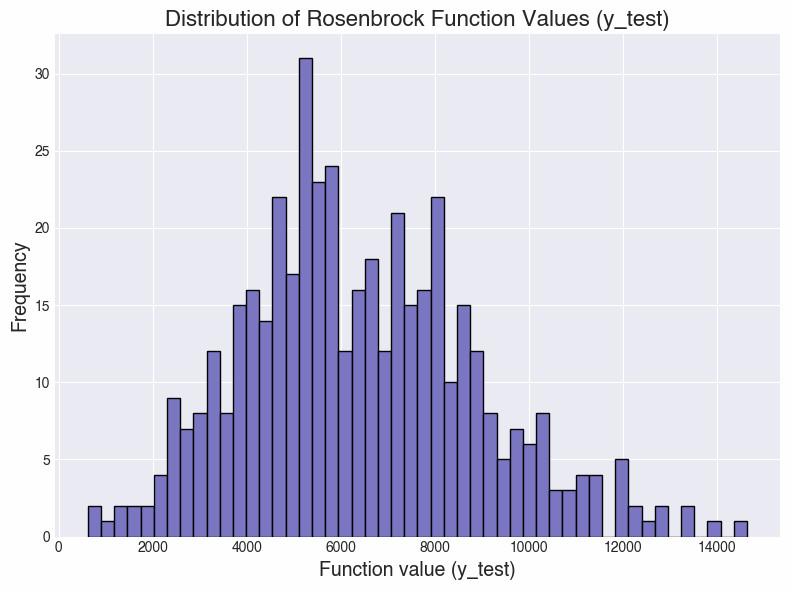

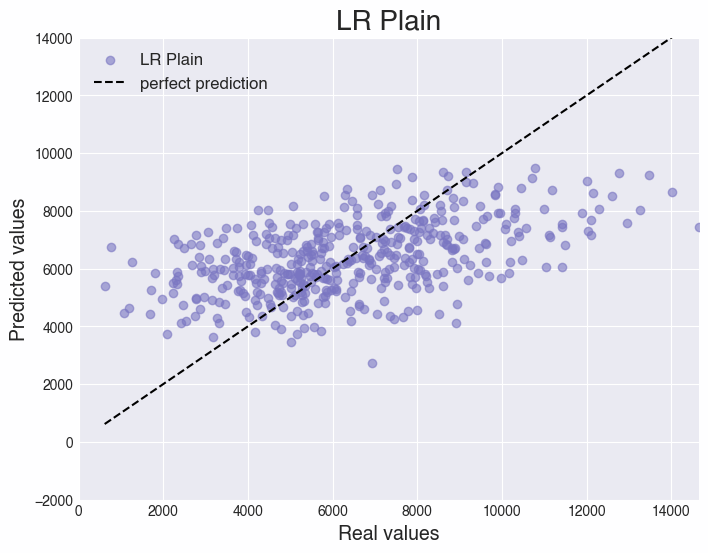

lr train: 35.6226067581376


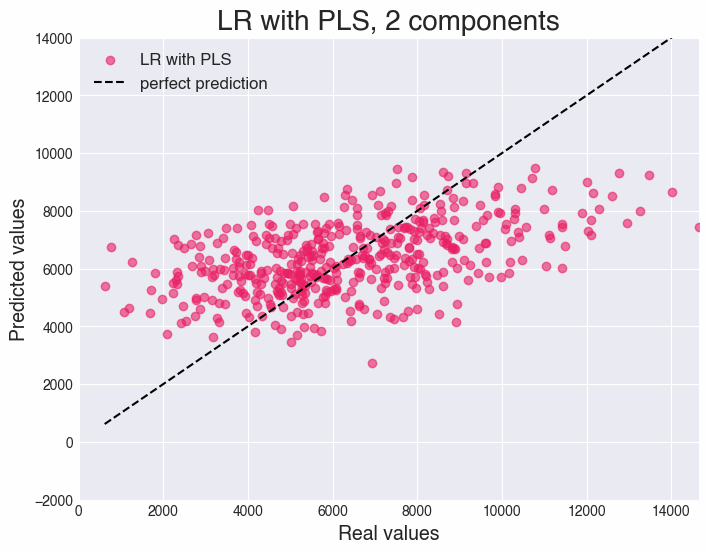

rl pls 35.62904829543708


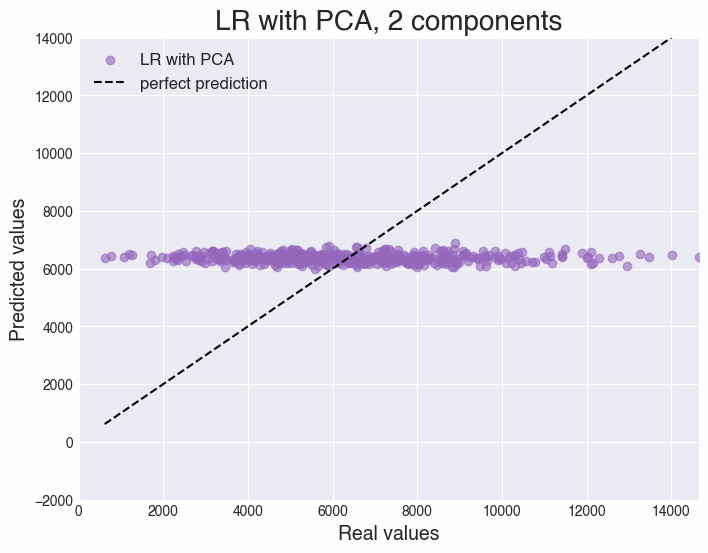

lrpcr train: 40.803994592836965


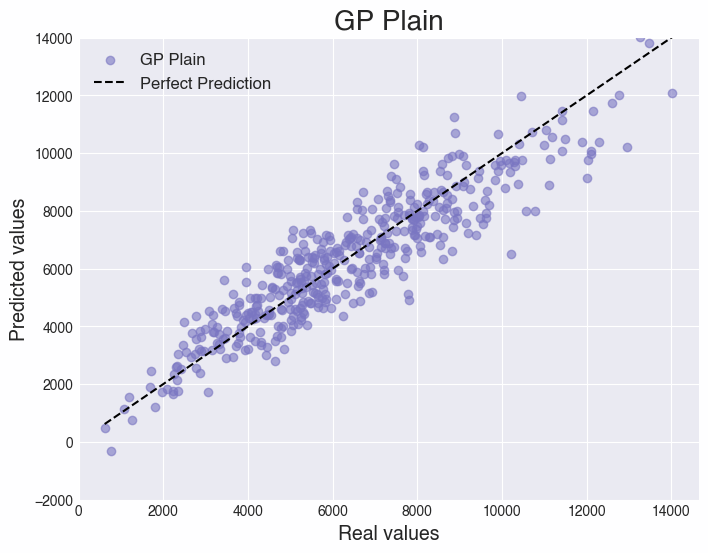

gp train: 5.324991989401438e-07

[ Gaussian Process with PLS (Sklearn) ]


/Users/yanmuller/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


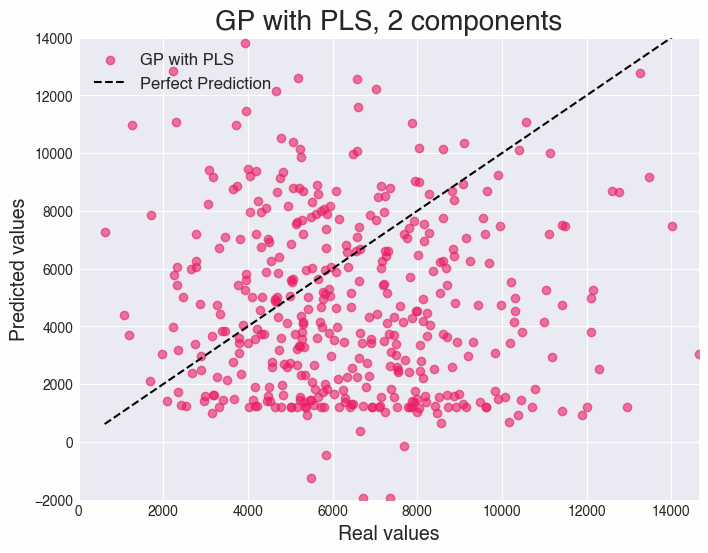

Relative Error Training GP+PLS: 7.110512814572343e-07


/Users/yanmuller/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


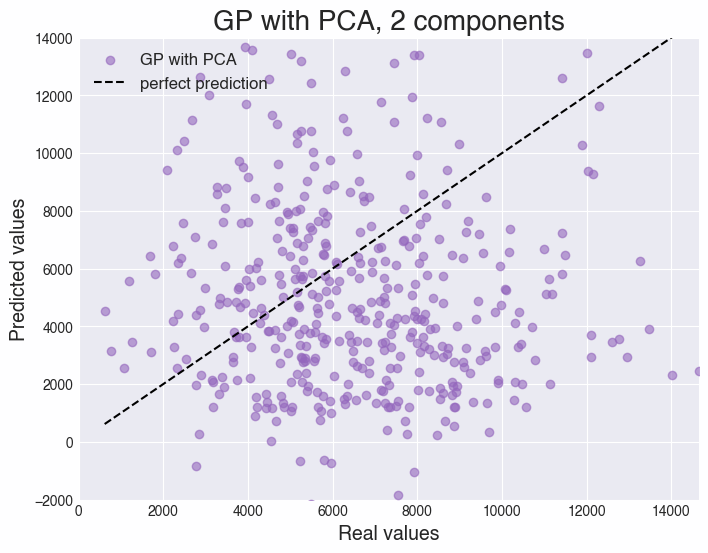

gppcr train: 1.0186597216341715e-07

Table 1: Linear Regression  Errors
Comp. |  Model     | RelErr |   MAE   |  RMSE  |   R²  |   L2
------------------------------------------------------------
  0 |  LR Plain   |     37.11% | 1702.58 | 2144.71 |  0.256 | 4599768.2736
  2 |  LR PLS     |     37.08% | 1701.14 | 2143.80 |  0.257 | 4595866.0087
  2 |  LR PCR     |     44.21% | 2011.07 | 2497.02 | -0.008 | 6235098.5446
------------------------------------------------------------

Table 2: Gaussian Process  Errors
Comp. |  Model     | RelErr |   MAE   |  RMSE  |   R²  |   L2   | l2train
------------------------------------------------------------
  0 |  GP Plain   |     14.02% | 800.17 | 1006.28 |  0.836 | 1012594.5025 |      0.00
  2 |  GP PLS     |     99.40% | 5196.11 | 8852.94 | -11.671 | 78374532.4175 |      0.00
  2 |  GP PCR     |     76.30% | 4196.03 | 5441.80 | -3.788 | 29613193.6033 |      0.00
------------------------------------------------------------

Table 3: Linear Regressi

In [15]:


import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import gc
from pyDOE2 import lhs
import seaborn as sns
from scipy.stats import qmc
#plt.style.use('/Users/yanmuller/Desktop/pitayasmoothie-light.mplstyle')


# Rosenbrock Function
def rosenbrock(X):
    X = np.asarray(X)
    return np.sum( 100*(X[:, 1:] - X[:, :-1]**2)**2 + (1 - X[:, :-1])**2, axis=1)

# Settings
n_features = 15
seed = 42

TrainPoints = n_features * 60
TestPoints = n_features * 30

# Latin Hypercube Sampler with Seed
sampler_train = qmc.LatinHypercube(d=n_features, seed=seed)
X_train =   4 * sampler_train.random(TrainPoints) - 2

sampler_test = qmc.LatinHypercube(d=n_features, seed=seed +1 )  
X_test =   4 * sampler_test.random(TestPoints) - 2


y_train =rosenbrock(X_train)
y_test = rosenbrock(X_test)



# Scaling
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))


#Test PLot
plt.figure(figsize=(8, 6))
plt.hist(y_test, bins=50, edgecolor='black')
plt.xlabel('Function value (y_test)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Rosenbrock Function Values (y_test)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Warm-up ---
X_dummy = np.random.rand(100, 10)
y_dummy = np.random.rand(100)
_ = LinearRegression().fit(X_dummy, y_dummy)
_ = GaussianProcessRegressor().fit(X_dummy, y_dummy)

# --- Evaluation ---
components_list = [2]
results = []

import gc
gc.collect()

# --- LR Plain ---
lr_plain = LRnoPLS(0)
results.append({
    "n_components": 0,
    "model": "LR Plain",
    "rel": lr_plain["rel_plain_test"],
    "mae": lr_plain["mae_plain_test"],
    "rmse": lr_plain["rmse_plain_test"],
    "r2": lr_plain["r2_plain_test"],
    "mse" : lr_plain["mse_test"],
    "TTot": lr_plain["time_total"],
    "TProj": None,
    "TTrain": lr_plain["time_train"],
    "TPred": lr_plain["time_pred"]
})

for n in components_list:
    gc.collect()

    # LR PLS
    lr_pls = LRPLSSk(n)
    results.append({
        "n_components": n,
        "model": "LR PLS",
        "rel": lr_pls["rel_pls_test"],
        "mae": lr_pls["mae_pls_test"],
        "rmse": lr_pls["rmse_pls_test"],
        "r2": lr_pls["r2_pls_test"],
        "mse" : lr_pls["mse_test"],
        "TTot": lr_pls["time_pls_total"],
        "TProj": lr_pls["time_pls_proj"],
        "TTrain": lr_pls["time_pls_train"],
        "TPred": lr_pls["time_pls_pred"]
    })

    # LR PCR
    lr_pcr = LRPCR(n)
    results.append({
        "n_components": n,
        "model": "LR PCR",
        "rel": lr_pcr["rel_pcr_test"],
        "mae": lr_pcr["mae_pcr_test"],
        "rmse": lr_pcr["rmse_pcr_test"],
        "r2": lr_pcr["r2_pcr_test"],
        "mse" : lr_pcr["mse_test"],
        "TTot": lr_pcr["time_pcr_total"],
        "TProj": lr_pcr["time_pcr_proj"],
        "TTrain": lr_pcr["time_pcr_train"],
        "TPred": lr_pcr["time_pcr_pred"]
    })

# --- GP Plain ---
gp_plain = GPnoPLS()
results.append({
    "n_components": 0,
    "model": "GP Plain",
    "rel": gp_plain["rel_gp_plain_test"],
    "mae": gp_plain["mae_gp_plain_test"],
    "rmse": gp_plain["rmse_gp_plain_test"],
    "r2": gp_plain["r2_gp_plain_test"],
    "mse" : gp_plain["mse_test"],
    "mset" : gp_plain["mse_train"],
    "TTot": gp_plain["time_gp_plain_total"],
    "TProj": None,
    "TTrain": gp_plain["time_gp_plain_train"],
    "TPred": gp_plain["time_gp_plain_pred"]
})

# --- Models with (PLS + PCR) ---
for n in components_list:
    gc.collect()
    # GP PLS
    gp_pls = GPPLSSk(n)
    results.append({
        "n_components": n,
        "model": "GP PLS",
        "rel": gp_pls["rel_gp_pls_test"],
        "mae": gp_pls["mae_gp_pls_test"],
        "rmse": gp_pls["rmse_gp_pls_test"],
        "r2": gp_pls["r2_gp_pls_test"],
        "mse" : gp_pls["mse_test"],
        "mset" : gp_plain["mse_train"],
        "TTot": gp_pls["time_gp_pls_total"],
        "TProj": gp_pls["time_gp_pls_proj"],
        "TTrain": gp_pls["time_gp_pls_train"],
        "TPred": gp_pls["time_gp_pls_pred"]
    })

    # GP PCR
    gp_pcr = GPPCR(n)
    results.append({
        "n_components": n,
        "model": "GP PCR",
        "rel": gp_pcr["rel_gp_pcr_test"],
        "mae": gp_pcr["mae_gp_pcr_test"],
        "rmse": gp_pcr["rmse_gp_pcr_test"],
        "r2": gp_pcr["r2_gp_pcr_test"],
        "mse" : gp_pcr["mse_test"],
        "mset" : gp_plain["mse_train"],
        "TTot": gp_pcr["time_gp_pcr_total"],
        "TProj": gp_pcr["time_gp_pcr_proj"],
        "TTrain": gp_pcr["time_gp_pcr_train"],
        "TPred": gp_pcr["time_gp_pcr_pred"]
    })

# --- Tables ---
print("\nTable 1: Linear Regression  Errors")
print("Comp. |  Model     | RelErr |   MAE   |  RMSE  |   R²  |   L2")
print("-" * 60)
for row in results:
    if row["model"].startswith("LR"):
        l2 = f"{row['mse']:.4f}" if row["mse"] is not None else "  --- "
        print(f"{row['n_components']:>3} |  {row['model']:<10} | {row['rel']:9.2f}% | "
              f"{row['mae']:6.2f} | {row['rmse']:6.2f} | {row['r2']:6.3f} | {l2:>9}")
print("-" * 60)

print("\nTable 2: Gaussian Process  Errors")
print("Comp. |  Model     | RelErr |   MAE   |  RMSE  |   R²  |   L2   | l2train")
print("-" * 60)
for row in results:
    if row["model"].startswith("GP"):
        l2 = f"{row['mse']:.4f}" if row["mse"] is not None else "  --- "
        print(f"{row['n_components']:>3} |  {row['model']:<10} | {row['rel']:9.2f}% | "
              f"{row['mae']:6.2f} | {row['rmse']:6.2f} | {row['r2']:6.3f} | {l2:>9} | {row['mset']:9.2f}")
print("-" * 60)

print("\nTable 3: Linear Regression Times (in Seconds)")
print("Comp. |  Model   | TTot  | TProj | TTrain | TPred ")
print("-" * 55)
for row in results:
    if row["model"].startswith("LR"):
        tproj = f"{row['TProj']:.4f}" if row["TProj"] is not None else "  --- "
        print(f"{row['n_components']:>3} |  {row['model']:<8} | {row['TTot']:6.4f} | {tproj:>6} | "
              f"{row['TTrain']:6.4f} | {row['TPred']:6.4f}")
print("-" * 55)

print("\nTable 4: Gaussian Process Times (in Seconds)")
print("Comp. |  Model   | TTot  | TProj | TTrain | TPred ")
print("-" * 55)
for row in results:
    if row["model"].startswith("GP"):
        tproj = f"{row['TProj']:.4f}" if row["TProj"] is not None else "  --- "
        print(f"{row['n_components']:>3} |  {row['model']:<8} | {row['TTot']:6.4f} | {tproj:>6} | "
              f"{row['TTrain']:6.4f} | {row['TPred']:6.4f}")
print("-" * 55)


